# Student performance, dataset analysis

### Import libraries

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

### Data loading

In [1]:
data = pd.read_csv('data/student-mat.csv', sep=';', header='infer')

### Check rows and columns

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

We observe a total of 395 student profiles with no missing value in 'student-mat.csv' and a total of 33 variables with 17 of them being nominal variables.

Another observation that we can make is that several variables in the dataset can not be modified for a student and thus these variables can not be used to decide what kind of action we can make to improve the student performance, for example we can not tell a student that the average performance of female is better than male thus the student needs to change his gender in order to improve his performance. 

A lot of these variables are related to the background of the student, for example the status of the student's parents. We can safely hypothesis that depending on the background of the student, the variables such as goout which corresponds to the frequency of going out with friends will have different impact on the school performance. So what we can do is first separate from the dataset all the variables that are not useful for the decision-making process since they are mostly background information. Then we can group the different backgrounds into clusters in order to group students of similar background. And finally, we can exploit the remaining variables to see which of them has the most impact on the performance among student of similar background and give an advice based on it.

One drawback of the method is that some variables related to the background may be irrevelant, but since we are using them, we may create 2 different backgrounds due to them and when we try to find the importance of non-background-related variables for a given background, we may miss some important data that were stored in the other background. Another drawback is when the student in a certain background is the best student with for example a grade of 15, as such looking at similar background students won't help the student.

A priori, the background-related variables are : school, sex, age, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, failures, nursery, G1 and G2.  

The non-background-related variables that can be used for the decision-making advice would be : studytime, schoolsup, famsup, paid, activities, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health and absences.

We consider G3 as the final achievement of the student and the target variable that we want to improve through our advice, meanwhile G2 will represented the current level of the student.

### Looking for outliers

In [4]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


age and absences seem like to contain some extreme values, as the difference between the 3-quartile and the max value is quite sharp. Let's look at absences :

Text(0.5, 1.0, 'absences distribution')

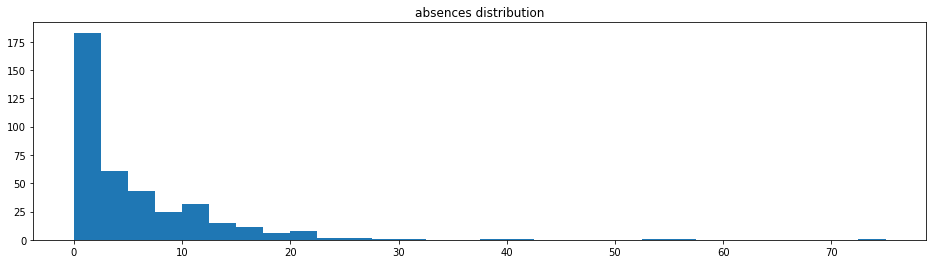

In [2]:
absences = data['absences']

plt.figure(figsize=(16,4))
plt.hist(absences, bins = 30)
plt.title('absences distribution')

Looking at the absences distribution, we observe that it is unequal with outliers when absences is greater than 20. It may be interesting to group absences into categories of absences.

Text(0.5, 1.0, 'G3 distribution among students with more than 20 absences')

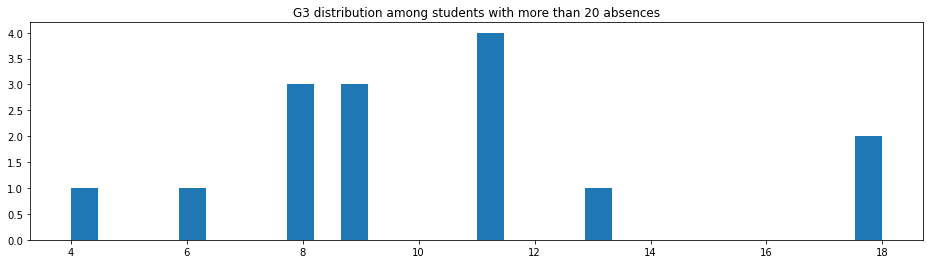

In [7]:
g3_absences_20 = data.iloc[(absences > 20).to_numpy()]['G3']
plt.figure(figsize=(16,4))
plt.hist(g3_absences_20, bins = 30)
plt.title('G3 distribution among students with more than 20 absences')

The repartition is spread out and it seems like that high absenteism is not a reason for bad grades.

### Missing data ?

In [8]:
data.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

### Variable correlations

In [9]:
data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.093040,-0.153198,-0.117142
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.160612,0.135880,0.097820
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
Dalc,0.131125,0.019834,0.002386,0.138325,-0.196019,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660


Looking at the correlation matrix and the nominal variables:
1) G1 and G2 are extremely correlated (r = 0.85) and we can safely remove G1 and keep G2 in the dataset.

2) The parents' education are also related (r = 0.62).

3) The alcohol consumption during schoolday and the weekend are related (r = 0.64) and we may consider removing both of them to replace them with a simple variable alcohol_consumption.

4) While not in the table due to them being nominal variables, schoolsup, famsup and paid can be grouped into a single variable "additional_classes" as they convey the same idea that the student is taking more classes.

### Data processing

In [2]:
y = data['G3']
X = data.drop(['G3','G1'], 1)

background_variables = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","guardian","traveltime","failures","nursery","G2"]
predictor_variables = ["studytime","schoolsup","famsup","paid","activities","higher","internet","romantic","famrel","freetime","goout","Dalc","Walc","health","absences"]
X_background = X[background_variables]
X_advice = X[predictor_variables]

In [11]:
X_background.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,failures,nursery,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,0,yes,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,0,no,5
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,3,yes,8
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,0,yes,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,0,yes,10


Transform nominal variables into categorical :

In [3]:
columns_name = []
for name in X_background.columns:
    if X_background[name].dtype == 'object':
        columns_name.append(name)

X_background_numeric = pd.get_dummies(X_background, columns = columns_name, drop_first = True)

In [4]:
X_background_numeric.head()

,age,Medu,Fedu,traveltime,failures,G2,school_MS,sex_M,address_U,famsize_LE3,...,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,nursery_yes
0,18,4,4,2,0,6,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
1,17,1,1,1,0,5,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,15,1,1,1,3,8,0,0,1,1,...,0,1,0,0,0,1,0,1,0,1
3,15,4,2,1,0,14,0,0,1,0,...,0,0,1,0,1,0,0,1,0,1
4,16,3,3,1,0,10,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [4]:
columns_name = []
for name in X_advice.columns:
    if X_advice[name].dtype == 'object':
        columns_name.append(name)

X_advice_numeric = pd.get_dummies(X_advice, columns = columns_name, drop_first = True)

### General model

To give general advice to student, what we want to do here is to look for which factors influences the most the student grades.
We will take advantage of the linear model and its explainability power to look for good advices.
We first tried to train a linear model with only non-related-background variables but these variables were not able to explain well the final grade and as such in order to have a good model, we use all the variables. Once we had trained the model, we can look for the coefficient of each variable and learn directly which variables affect the most the final grade. Of course, we will have to filter background-related variables as they are factors that we can't control and thus we can't use for advice. 

In [5]:
# get a pandas.DataFrame with all the initial variables transformed to numerical variables
X_numeric = pd.concat([X_background_numeric, X_advice_numeric], axis=1)
# standardize the dataset, useful when looking for the coefficients of the model since they will be on the same scale
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_numeric.to_numpy())

# let's check the overall performance of the linear model to explain the final grade
# we test different split of the dataset into train and test
train_score = []
test_score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_standardized, y.to_numpy(), test_size=0.3)
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    train_score.append(regr.score(X_train, y_train))
    test_score.append(regr.score(X_test, y_test))

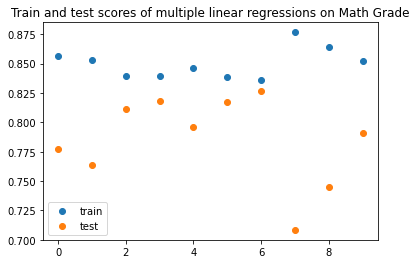

In [6]:
plt.scatter(range(10), train_score, label="train")
plt.scatter(range(10), test_score, label="test")
plt.legend()
plt.title('Train and test scores of multiple linear regressions on Math Grade')
plt.show()

In [7]:
general_linear = LinearRegression()
general_linear.fit(X_standardized, y.to_numpy())
print(pd.DataFrame([general_linear.coef_], columns=X_numeric.columns).iloc[0].sort_values(ascending=False))

G2                   4.097418
absences             0.376229
famrel               0.340182
Walc                 0.204844
school_MS            0.143957
Medu                 0.119705
sex_M                0.107474
guardian_mother      0.103536
traveltime           0.096531
health               0.083799
schoolsup_yes        0.081962
reason_reputation    0.069457
higher_yes           0.068382
freetime             0.066088
reason_other         0.058472
famsup_yes           0.054069
Fjob_health          0.043703
address_U            0.031054
Mjob_services        0.027296
guardian_other       0.024392
famsize_LE3          0.016329
paid_yes             0.008452
goout                0.008217
Fjob_teacher        -0.014961
Mjob_other          -0.016239
Mjob_teacher        -0.019658
Pstatus_T           -0.020640
Mjob_health         -0.029897
studytime           -0.055139
internet_yes        -0.066785
nursery_yes         -0.089905
reason_home         -0.095490
romantic_yes        -0.095700
Fedu      

Let's look for only non-background-related variables :

In [8]:
print(pd.DataFrame([general_linear.coef_], columns=X_numeric.columns)[X_advice_numeric.columns].iloc[0].sort_values(ascending=False))

absences          0.376229
famrel            0.340182
Walc              0.204844
health            0.083799
schoolsup_yes     0.081962
higher_yes        0.068382
freetime          0.066088
famsup_yes        0.054069
paid_yes          0.008452
goout             0.008217
studytime        -0.055139
internet_yes     -0.066785
romantic_yes     -0.095700
Dalc             -0.165875
activities_yes   -0.179818
Name: 0, dtype: float64


In [9]:
print(pd.DataFrame([np.abs(general_linear.coef_)], columns=X_numeric.columns)[X_advice_numeric.columns].iloc[0].sort_values(ascending=False))

absences          0.376229
famrel            0.340182
Walc              0.204844
activities_yes    0.179818
Dalc              0.165875
romantic_yes      0.095700
health            0.083799
schoolsup_yes     0.081962
higher_yes        0.068382
internet_yes      0.066785
freetime          0.066088
studytime         0.055139
famsup_yes        0.054069
paid_yes          0.008452
goout             0.008217
Name: 0, dtype: float64


We can conclude that generally, absences, famrel, Walc, activities and Dalc are the factors that influence the most the student grade with activities and Dalc having a negative influence on student.

### Personalized Solution

The previous model was useful to learn about general advices. Here we will try to give a more personalized advices, instead of looking at all the student, we will try to build a model in which we will look for student of similar background, and we will train a linear model to learn about specific factors that influence this group of students.

To look for student of similar background, we will use the k-mean algorithm.

In [128]:
def calculate_WSS(points, kmax):
  sse = []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    sse.append(kmeans.inertia_)
  return sse

X_background_array = X_background_numeric.to_numpy()
X_background_standardize = StandardScaler().fit_transform(X_background_array)

sse = calculate_WSS(X_background_array, 20)
sse2 = calculate_WSS(X_background_standardize, 20)

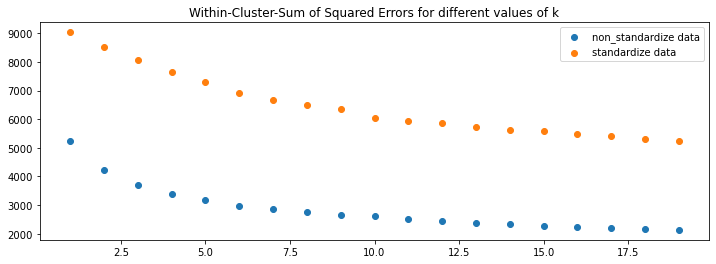

In [129]:
plt.figure(figsize=(12,4))
plt.scatter(range(1,len(sse)+1), sse, label="non_standardize data")
plt.scatter(range(1,len(sse2)+1), sse2, label="standardize data")
plt.legend()
plt.title('Within-Cluster-Sum of Squared Errors for different values of k')
plt.show()

The elbow method to determine the optimal k is ambiguous here.

In [130]:
def calculate_sil(points, kmax):
    sil = []
    for k in range(2, kmax+1):
      kmeans = KMeans(n_clusters = k).fit(points)
      labels = kmeans.labels_
      sil.append(silhouette_score(points, labels, metric = 'euclidean'))
    return sil
    
sil = calculate_sil(X_background_array, 20)
sil2 = calculate_sil(X_background_standardize, 20)

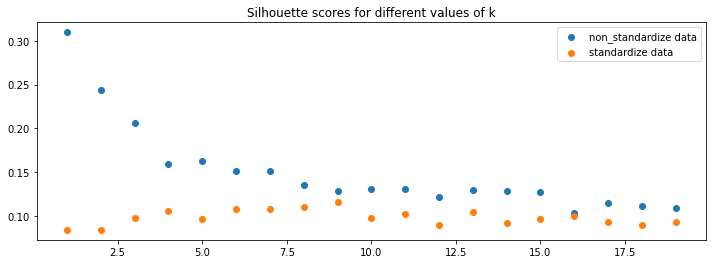

In [131]:
plt.figure(figsize=(12,4))
plt.scatter(range(1,len(sil)+1), sil, label="non_standardize data")
plt.scatter(range(1,len(sil2)+1), sil2, label="standardize data")
plt.legend()
plt.title('Silhouette scores for different values of k')
plt.show()

The global maximum score for the standardize data is obtained with k = 9. We will keep this number.

In [132]:
kmeans = KMeans(n_clusters=9).fit(X_background_array)
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print("Number of students per cluster :", counts)

Number of students per cluster : [50 59 44 51 58 20 60 40 13]


Here we have a fix number of clusters, but we can choose to have a greater number of clusters as we can affine our research of similar profiles to be stricter. However the more we have cluster, the more we will look for extremely similar profile and when doing so, we would somehow get more homogeneous clusters which will make us unable to learn anything as the data would be extremely similar within a cluster

Use-case : let's assume that our student belongs to the cluster 4, we choose to get all student with similar background to him in the dataset by getting all the student in cluster 4.

In [133]:
X_advice_cluster_numeric = X_advice_numeric.iloc[kmeans.labels_ == 6]
X_advice_cluster_array = X_advice_cluster_numeric.to_numpy()
y_cluster = y.iloc[kmeans.labels_ == 6]
y_cluster_array = y_cluster.to_numpy()

In [134]:
X_advice_cluster_numeric.head()

,studytime,famrel,freetime,goout,Dalc,Walc,health,absences,schoolsup_yes,famsup_yes,paid_yes,activities_yes,higher_yes,internet_yes,romantic_yes
2,2,4,3,2,2,3,3,10,1,0,1,0,1,1,0
4,2,4,3,2,1,2,5,4,0,1,1,0,1,0,0
11,3,5,2,2,1,1,4,4,0,1,0,1,1,1,0
17,2,5,3,2,1,1,4,4,1,1,0,1,1,0,0
25,1,1,2,2,1,3,5,14,0,1,1,0,1,1,0


Now among all of these students from the same cluster, we wish to see the importance of non-background related variables in determining their achievement. To do so, we will reuse a linear model.

In [141]:
# since we are dealing with extremely small dataset, we use the LeaveOneOut cross-validation to check for the model performance.
loo = LeaveOneOut()
train_score = []
test_rmse_score = []

X_advice_cluster_standardize = StandardScaler().fit_transform(X_advice_cluster_array)

for train_index, test_index in loo.split(X_advice_cluster_standardize):
    X_train, X_test = X_advice_cluster_standardize[train_index], X_advice_cluster_standardize[test_index]
    y_train, y_test = y_cluster_array[train_index], y_cluster_array[test_index]
    
    regr = LinearRegression().fit(X_train, y_train)
    train_score.append(regr.score(X_train, y_train))
    test_rmse_score.append(abs(regr.predict(X_test)[0]-y_test[0]))

In [142]:
print("Average R :", sum(train_score)/len(train_score))

Average R : 0.3021249247983567


In [143]:
print("RMSE test score :", sum(test_rmse_score)/len(test_rmse_score))

RMSE test score : 1.4286495951573228


In [126]:
regr = LinearRegression().fit(X_advice_cluster_standardize, y_cluster_array)
pd.DataFrame([regr.coef_], columns=X_advice_cluster_numeric.columns).iloc[0].sort_values(ascending=False)

famrel            1.323118
schoolsup_yes     1.061366
higher_yes        1.029822
romantic_yes      0.628568
health            0.595153
Walc              0.478032
internet_yes      0.405978
studytime         0.188385
paid_yes          0.151221
goout            -0.259537
absences         -0.401438
Dalc             -0.543856
activities_yes   -0.655683
freetime         -0.825944
famsup_yes       -1.610230
Name: 0, dtype: float64

In [147]:
regr.score(X_advice_cluster_standardize, y_cluster_array)

0.2965937149139002

Unfortunately, it seems like that the linear model can't fit well X_advice_cluster_standardize to y_cluster_array.

In [150]:
regr = RandomForestRegressor(max_depth=4).fit(X_advice_cluster_standardize, y_cluster_array)

print("Random forest R score :", regr.score(X_advice_cluster_standardize, y_cluster_array))

pd.DataFrame([regr.feature_importances_], columns=X_advice_cluster_numeric.columns).iloc[0].sort_values(ascending=False)

Random forest R score : 0.7025983629941247


goout             0.210154
studytime         0.154296
schoolsup_yes     0.106257
famrel            0.089149
freetime          0.086951
absences          0.076732
Walc              0.067505
romantic_yes      0.054172
health            0.048679
activities_yes    0.034300
famsup_yes        0.020776
paid_yes          0.019249
Dalc              0.017224
internet_yes      0.011623
higher_yes        0.002933
Name: 0, dtype: float64

Now that we have the feature importances, we can sort it and list the features according to its importance and we know what kind of action to put in priority. For example, we will first check the quality of the student family relationship, then we will check if the student is missing too much classes, etc.

One thing missing here is the cost of an action, we may try to improve first the relation between the student and its parents to improve its study environment but if the action is too costly we may think about trying to encourage no skipping classes, etc.

### Conclusion

We were able to create a pipeline in which we could group student of similar backgrounds. By looking at students from similar background, we were able to establish within this group which variables affected the most the student performance and from this we were able to choose which action to priotize.

One drawback of the method happen when for example the student in the cluster happened to be the best student, or when all student from the same cluster happen to have the same grade. On such a case, we are unable to give any good personalized advice. But we can rely on the general model we built to give good general advices.

A possible solution to tackle the drawback of the method is to create an extended model in which we do not only create a model from a single cluster, but from multiple clusters that are close to the student profile. And on such the case, it may be worth to use a 2d-Kohonen map to perform the clustering, as finding cluster neighborhood become trivial.

Finally, we made an application based on this notebook.